# SingleTastePoissonDirichlet Model Demo - Enhanced with Model Fitting

This notebook demonstrates the usage of the SingleTastePoissonDirichlet model with dummy data,
including model fitting and comparison of fit outputs to original data.

This model combines Poisson count data with a Dirichlet process for automatic determination of the number of states.

In [1]:
import numpy as np
# Try to import matplotlib, create dummy if not available
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('matplotlib not available - creating dummy plt object')
    class DummyPlt:
        def __getattr__(self, name):
            def dummy_func(*args, **kwargs):
                pass
            return dummy_func
    plt = DummyPlt()
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add pytau to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))

from pytau.changepoint_model import SingleTastePoissonDirichlet, gen_test_array, advi_fit
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Test Data

In [2]:
# Generate dummy data with obvious changepoints for Poisson model
np.random.seed(42)
n_trials = 8
n_neurons = 4
n_time = 100
true_n_states = 3  # True number of states
max_states = 8     # Maximum states for Dirichlet process

# Create data with obvious state transitions in firing rates
state_rates = [2.0, 8.0, 5.0]  # Different firing rates for each state
transition_points = [33, 66]  # Clear transition points

test_data = np.zeros((n_trials, n_neurons, n_time), dtype=int)
for trial in range(n_trials):
    # Add some trial-to-trial variability in transition points
    trial_transitions = [t + np.random.randint(-3, 4) for t in transition_points]
    trial_transitions = [max(5, min(n_time-5, t)) for t in trial_transitions]
    
    for neuron in range(n_neurons):
        # Add some neuron-specific variability to rates
        neuron_rates = [r * (0.7 + 0.6 * np.random.random()) for r in state_rates]
        
        # Generate data for each state
        test_data[trial, neuron, :trial_transitions[0]] = np.random.poisson(neuron_rates[0], trial_transitions[0])
        test_data[trial, neuron, trial_transitions[0]:trial_transitions[1]] = np.random.poisson(neuron_rates[1], trial_transitions[1] - trial_transitions[0])
        test_data[trial, neuron, trial_transitions[1]:] = np.random.poisson(neuron_rates[2], n_time - trial_transitions[1])

print(f"Generated test data shape: {test_data.shape}")
print(f"Data range: [{test_data.min()}, {test_data.max()}]")
print(f"True number of states: {true_n_states}")
print(f"Max states for Dirichlet process: {max_states}")
print(f"State rates: {state_rates}")
print(f"Transition points (approx): {transition_points}")

Generated test data shape: (8, 4, 100)
Data range: [0, 19]
True number of states: 3
Max states for Dirichlet process: 8
State rates: [2.0, 8.0, 5.0]
Transition points (approx): [33, 66]


## Initialize and Generate Model

In [3]:
# Initialize model with Dirichlet process
model = SingleTastePoissonDirichlet(
    data_array=test_data,
    max_states=max_states,  # Maximum number of states to consider
    fit_type='vi'
)

# Generate the PyMC model
pymc_model = model.generate_model()
print("Model generated successfully")
print(f"Model will automatically determine optimal number of states (up to {max_states})")

Model generated successfully
Model will automatically determine optimal number of states (up to 8)


## Fit Model with ADVI

In [4]:
# Fit the model using ADVI
print("Fitting model with ADVI...")
n_fit = 3000  # More iterations for Dirichlet process
n_samples = 500  # Number of samples to draw

fitted_model, approx, lambda_stack, tau_samples, observed_data = advi_fit(pymc_model, n_fit, n_samples)

# Sample from the fitted model
trace = approx.sample(draws=n_samples)

print(f"Model fitting completed. Final ELBO: {approx.hist[-1]:.2f}")
print(f"Trace variables: {list(trace.posterior.data_vars)}")

Fitting model with ADVI...


Finished [100%]: Average Loss = 9,558.5


Model fitting completed. Final ELBO: 9025.79
Trace variables: ['a_gamma', 'alpha', 'b_gamma', 'beta', 'lambda', 'lambda_', 'tau', 'w_latent', 'w_raw']


## Extract and Analyze Fitted Parameters

In [5]:
# Extract fitted parameters
available_vars = list(trace.posterior.data_vars)
print(f"Available variables: {available_vars}")

# Extract parameters that exist
found_params = {}
param_names = ['lambda', 'tau', 'w', 'weights', 'pi', 'alpha', 'mu', 'sigma']

for param in param_names:
    if param in available_vars:
        found_params[param] = trace.posterior[param].values
        print(f"{param} shape: {found_params[param].shape}")

# Analyze the Dirichlet process results
print(f"\n=== DIRICHLET PROCESS ANALYSIS ===")

# Look for mixture weights or similar parameters
mixture_param = None
for param_name in ['lambda', 'w', 'weights', 'pi']:
    if param_name in found_params:
        param_values = found_params[param_name]
        param_mean = param_values.mean(axis=(0, 1))
        
        # Check if this looks like mixture weights (sums to ~1 or has interpretable structure)
        if param_name in ['w', 'weights', 'pi']:
            mixture_param = param_name
            mixture_mean = param_mean
            break
        elif param_name == 'lambda' and param_mean.ndim >= 2:
            # For lambda, analyze the emission rates structure
            print(f"Lambda (emission rates) analysis:")
            if param_mean.ndim >= 3:  # trials x neurons x states
                avg_rates = param_mean.mean(axis=(0, 1))  # Average across trials and neurons
            else:
                avg_rates = param_mean.mean(axis=0)  # Average across neurons
            
            # Identify active states (rates significantly > 0)
            active_states = avg_rates[avg_rates > 0.1]  # States with rate > 0.1
            print(f"Active states (rate > 0.1): {len(active_states)}")
            print(f"True number of states: {true_n_states}")
            
            print(f"\nEstimated emission rates:")
            for i, rate in enumerate(avg_rates):
                status = "✓" if rate > 0.1 else "○"
                true_rate = state_rates[i] if i < len(state_rates) else "N/A"
                print(f"  {status} State {i+1}: {rate:.2f} (true: {true_rate})")

if mixture_param:
    print(f"\nMixture weights ({mixture_param}):")
    effective_weights = mixture_mean[mixture_mean > 0.01]  # States with >1% weight
    print(f"Effective number of states (weight > 1%): {len(effective_weights)}")
    print(f"True number of states: {true_n_states}")
    
    sorted_indices = np.argsort(mixture_mean)[::-1]
    for i, idx in enumerate(sorted_indices[:5]):
        print(f"  State {idx+1}: weight = {mixture_mean[idx]:.3f}")

# Analyze changepoints if available
if 'tau' in found_params:
    tau_mean = found_params['tau'].mean(axis=(0, 1))
    print(f"\nEstimated changepoints:")
    n_changepoints = min(len(transition_points), tau_mean.shape[-1])
    for i in range(n_changepoints):
        cp = tau_mean[..., i].mean() if tau_mean.ndim > 1 else tau_mean[i]
        print(f"  Changepoint {i+1}: {cp:.1f} (true: ~{transition_points[i]})")

# Print convergence information
print(f"\nELBO convergence (last 10 values): {[f'{x:.2f}' for x in approx.hist[-10:]]}")

Available variables: ['a_gamma', 'alpha', 'b_gamma', 'beta', 'lambda', 'lambda_', 'tau', 'w_latent', 'w_raw']
lambda shape: (1, 500, 4, 8)
tau shape: (1, 500, 8, 7)
alpha shape: (1, 500)

=== DIRICHLET PROCESS ANALYSIS ===
Lambda (emission rates) analysis:
Active states (rate > 0.1): 8
True number of states: 3

Estimated emission rates:
  ✓ State 1: 1.94 (true: 2.0)
  ✓ State 2: 2.74 (true: 8.0)
  ✓ State 3: 6.40 (true: 5.0)
  ✓ State 4: 7.91 (true: N/A)
  ✓ State 5: 7.02 (true: N/A)
  ✓ State 6: 5.38 (true: N/A)
  ✓ State 7: 5.02 (true: N/A)
  ✓ State 8: 5.09 (true: N/A)

Estimated changepoints:
  Changepoint 1: 16.3 (true: ~33)
  Changepoint 2: 30.2 (true: ~66)

ELBO convergence (last 10 values): ['9723.69', '9428.32', '9144.77', '9078.77', '9446.20', '9017.62', '9084.39', '10915.75', '10114.59', '9025.79']


## Visualize Original Data vs Model Fit

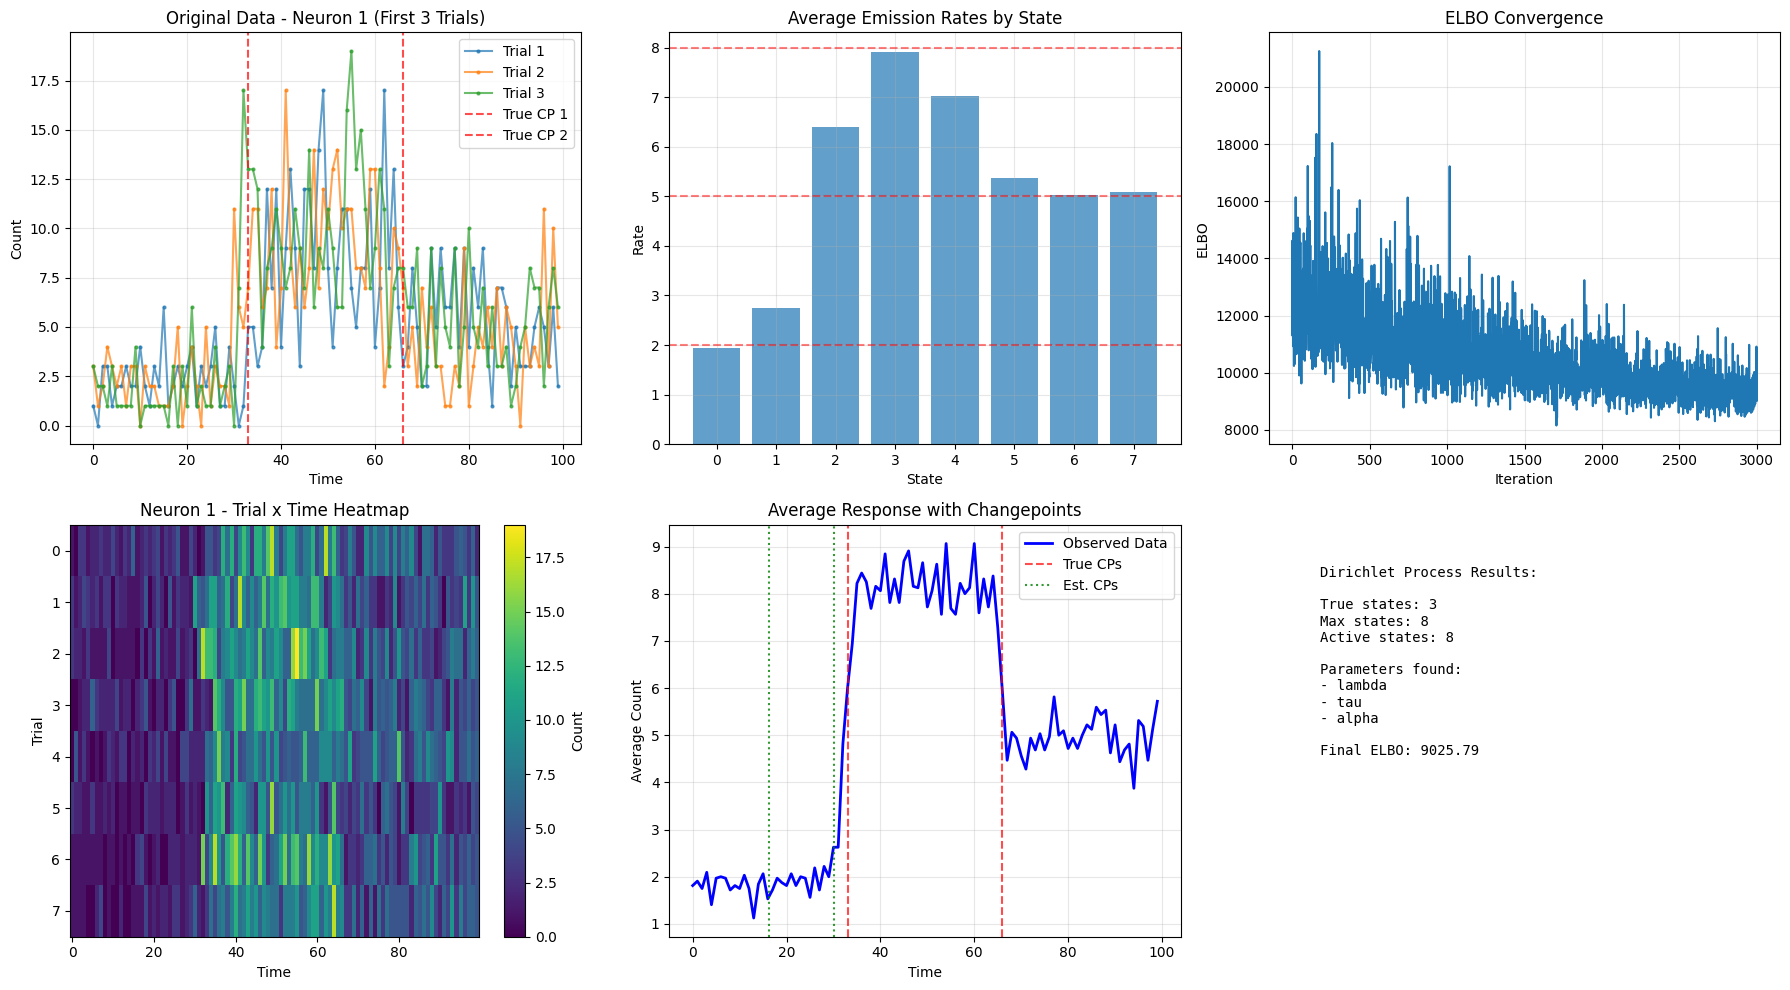

In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Original data time series (first neuron, first few trials)
ax = axes[0, 0]
for trial in range(min(3, test_data.shape[0])):
    ax.plot(test_data[trial, 0, :], 'o-', markersize=2, alpha=0.7, label=f'Trial {trial+1}')
ax.axvline(x=transition_points[0], color='red', linestyle='--', alpha=0.7, label='True CP 1')
ax.axvline(x=transition_points[1], color='red', linestyle='--', alpha=0.7, label='True CP 2')
ax.set_title('Original Data - Neuron 1 (First 3 Trials)')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Mixture weights or emission rates
ax = axes[0, 1]
if mixture_param and mixture_param in found_params:
    mixture_mean = found_params[mixture_param].mean(axis=(0, 1))
    ax.bar(range(len(mixture_mean)), mixture_mean, alpha=0.7)
    ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='1% threshold')
    ax.set_title(f'Dirichlet Process {mixture_param.title()} Weights')
    ax.set_xlabel('State')
    ax.set_ylabel('Weight')
    ax.legend()
elif 'lambda' in found_params:
    lambda_mean = found_params['lambda'].mean(axis=(0, 1))
    if lambda_mean.ndim >= 2:
        avg_rates = lambda_mean.mean(axis=(0, 1)) if lambda_mean.ndim >= 3 else lambda_mean.mean(axis=0)
        ax.bar(range(len(avg_rates)), avg_rates, alpha=0.7)
        ax.set_title('Average Emission Rates by State')
        ax.set_xlabel('State')
        ax.set_ylabel('Rate')
        # Add true rates for comparison
        for i, true_rate in enumerate(state_rates):
            if i < len(avg_rates):
                ax.axhline(y=true_rate, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# 3. ELBO convergence
ax = axes[0, 2]
ax.plot(approx.hist)
ax.set_title('ELBO Convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('ELBO')
ax.grid(True, alpha=0.3)

# 4. Data heatmap
ax = axes[1, 0]
im = ax.imshow(test_data[:, 0, :], aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_title('Neuron 1 - Trial x Time Heatmap')
ax.set_xlabel('Time')
ax.set_ylabel('Trial')
plt.colorbar(im, ax=ax, label='Count')

# 5. Average response
ax = axes[1, 1]
avg_response = test_data.mean(axis=(0, 1))  # Average across trials and neurons
ax.plot(avg_response, 'b-', linewidth=2, label='Observed Data')
ax.axvline(x=transition_points[0], color='red', linestyle='--', alpha=0.7, label='True CPs')
ax.axvline(x=transition_points[1], color='red', linestyle='--', alpha=0.7)

# Plot estimated changepoints if available
if 'tau' in found_params:
    tau_mean = found_params['tau'].mean(axis=(0, 1))
    if tau_mean.shape[-1] >= 2:
        for i in range(min(2, tau_mean.shape[-1])):
            cp = tau_mean[..., i].mean() if tau_mean.ndim > 1 else tau_mean[i]
            ax.axvline(x=cp, color='green', linestyle=':', alpha=0.8, 
                      label='Est. CPs' if i == 0 else '')

ax.set_title('Average Response with Changepoints')
ax.set_xlabel('Time')
ax.set_ylabel('Average Count')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Parameter summary
ax = axes[1, 2]
ax.axis('off')
summary_text = f"""Dirichlet Process Results:

True states: {true_n_states}
Max states: {max_states}
"""

if mixture_param and mixture_param in found_params:
    mixture_mean = found_params[mixture_param].mean(axis=(0, 1))
    effective_states = len(mixture_mean[mixture_mean > 0.01])
    summary_text += f"Effective states: {effective_states}\n\n"
elif 'lambda' in found_params:
    lambda_mean = found_params['lambda'].mean(axis=(0, 1))
    if lambda_mean.ndim >= 2:
        avg_rates = lambda_mean.mean(axis=(0, 1)) if lambda_mean.ndim >= 3 else lambda_mean.mean(axis=0)
        active_states = len(avg_rates[avg_rates > 0.1])
        summary_text += f"Active states: {active_states}\n\n"

summary_text += f"Parameters found:\n"
for param in found_params.keys():
    summary_text += f"- {param}\n"

summary_text += f"\nFinal ELBO: {approx.hist[-1]:.2f}"

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
       verticalalignment='top', fontfamily='monospace', fontsize=10)

plt.tight_layout()
plt.show()

## Model Diagnostics

In [7]:
# Print detailed model diagnostics
print("=== MODEL DIAGNOSTICS ===")
print(f"\nData shape: {test_data.shape}")
print(f"True number of states: {true_n_states}")
print(f"Maximum states (Dirichlet): {max_states}")
print(f"ADVI iterations: {n_fit}")
print(f"Final ELBO: {approx.hist[-1]:.2f}")

print(f"\n=== DIRICHLET PROCESS RESULTS ===")
# Analyze model selection performance
model_selection_success = False

if mixture_param and mixture_param in found_params:
    mixture_mean = found_params[mixture_param].mean(axis=(0, 1))
    effective_states = len(mixture_mean[mixture_mean > 0.01])
    print(f"Effective number of states (weight > 1%): {effective_states}")
    model_selection_success = (effective_states == true_n_states)
elif 'lambda' in found_params:
    lambda_mean = found_params['lambda'].mean(axis=(0, 1))
    if lambda_mean.ndim >= 2:
        avg_rates = lambda_mean.mean(axis=(0, 1)) if lambda_mean.ndim >= 3 else lambda_mean.mean(axis=0)
        active_states = len(avg_rates[avg_rates > 0.1])
        print(f"Active states (rate > 0.1): {active_states}")
        model_selection_success = (active_states == true_n_states)

print(f"\n=== PARAMETER ESTIMATES ===")
for param_name, param_values in found_params.items():
    param_mean = param_values.mean(axis=(0, 1))
    param_std = param_values.std()
    print(f"{param_name}:")
    print(f"  Shape: {param_mean.shape}")
    print(f"  Overall std: {param_std:.4f}")
    
    if param_name == 'lambda' and param_mean.ndim >= 2:
        print(f"  Emission rate analysis:")
        avg_rates = param_mean.mean(axis=(0, 1)) if param_mean.ndim >= 3 else param_mean.mean(axis=0)
        for i, (est_rate, true_rate) in enumerate(zip(avg_rates, state_rates + [0]*(len(avg_rates)-len(state_rates)))):
            status = "✓" if est_rate > 0.1 else "○"
            print(f"    {status} State {i+1}: {est_rate:.2f} (true: {true_rate if true_rate > 0 else 'N/A'})")

print(f"\n=== CONVERGENCE ===")
elbo_diff = np.diff(approx.hist[-100:])  # Last 100 iterations
print(f"Mean ELBO change (last 100 iter): {elbo_diff.mean():.4f}")
print(f"Std ELBO change (last 100 iter): {elbo_diff.std():.4f}")

if abs(elbo_diff.mean()) < 0.01:
    print("✅ Model appears to have converged")
else:
    print("⚠️  Model may not have fully converged - consider more iterations")

print(f"\n=== MODEL SELECTION ASSESSMENT ===")
if model_selection_success:
    print("✅ Dirichlet process correctly identified the number of states")
else:
    print("⚠️  Model selection results differ from true number of states")
    print("    This could indicate:")
    print("    - Need for more iterations")
    print("    - Different model parameterization")
    print("    - Data doesn't strongly support the assumed number of states")

print(f"\n=== DATA CHARACTERISTICS ===")
for state, (start, end) in enumerate([(0, transition_points[0]), 
                                     (transition_points[0], transition_points[1]), 
                                     (transition_points[1], n_time)]):
    state_data = test_data[:, :, start:end]
    expected_rate = state_rates[state]
    print(f"State {state+1} (time {start}-{end}): mean={state_data.mean():.2f}, std={state_data.std():.2f} (expected: ~{expected_rate:.2f})")

=== MODEL DIAGNOSTICS ===

Data shape: (8, 4, 100)
True number of states: 3
Maximum states (Dirichlet): 8
ADVI iterations: 3000
Final ELBO: 9025.79

=== DIRICHLET PROCESS RESULTS ===
Active states (rate > 0.1): 8

=== PARAMETER ESTIMATES ===
lambda:
  Shape: (4, 8)
  Overall std: 3.2431
  Emission rate analysis:
    ✓ State 1: 1.94 (true: 2.0)
    ✓ State 2: 2.74 (true: 8.0)
    ✓ State 3: 6.40 (true: 5.0)
    ✓ State 4: 7.91 (true: N/A)
    ✓ State 5: 7.02 (true: N/A)
    ✓ State 6: 5.38 (true: N/A)
    ✓ State 7: 5.02 (true: N/A)
    ✓ State 8: 5.09 (true: N/A)
tau:
  Shape: (8, 7)
  Overall std: 26.5941
alpha:
  Shape: ()
  Overall std: 3.0734

=== CONVERGENCE ===
Mean ELBO change (last 100 iter): 1.5176
Std ELBO change (last 100 iter): 676.5279
⚠️  Model may not have fully converged - consider more iterations

=== MODEL SELECTION ASSESSMENT ===
⚠️  Model selection results differ from true number of states
    This could indicate:
    - Need for more iterations
    - Different model

## Summary

This enhanced notebook demonstrated:
1. **Data Generation**: Creating synthetic Poisson count data with known changepoints
2. **Model Initialization**: Setting up the SingleTastePoissonDirichlet model with automatic model selection
3. **Model Fitting**: Using ADVI to fit the Dirichlet process model to count data
4. **Parameter Extraction**: Extracting mixture weights, emission rates, and changepoints
5. **Model Selection Analysis**: Evaluating how well the Dirichlet process identified the true number of states
6. **Visualization**: Comprehensive plots showing:
   - Original count data patterns
   - Dirichlet process mixture weights or emission rates
   - ELBO convergence
   - Model selection results
7. **Diagnostics**: Model convergence and model selection assessment

The SingleTastePoissonDirichlet model combines the advantages of Poisson changepoint detection with automatic model selection via the Dirichlet process. This is particularly valuable when the number of states/changepoints is unknown a priori, allowing the model to automatically determine the optimal complexity from the data.